In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# ML Preprocessing and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# If using inside Kaggle's own notebook environment
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("nelgiriyewithana/credit-card-fraud-detection-dataset-2023")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/credit-card-fraud-detection-dataset-2023


In [3]:
import pandas as pd

# Use the downloaded path from kagglehub
df = pd.read_csv(f"{path}/creditcard_2023.csv")

# Quick preview
df.head()


,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [4]:
from sklearn.preprocessing import StandardScaler

# Drop 'id' column
df = df.drop(columns=['id'])

# Store target column
y = df['Class']

# Features to include
features = [col for col in df.columns if col not in ['Class', 'id']]

# Initialize scaler
scaler = StandardScaler()

# Scale only 'Amount'; keep other features as-is (already normalized)
df_scaled = df.copy()
df_scaled['Amount'] = scaler.fit_transform(df[['Amount']])

# Feature matrix
X = df_scaled.drop('Class', axis=1)

# Final check
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (568630, 29)
Shape of y: (568630,)


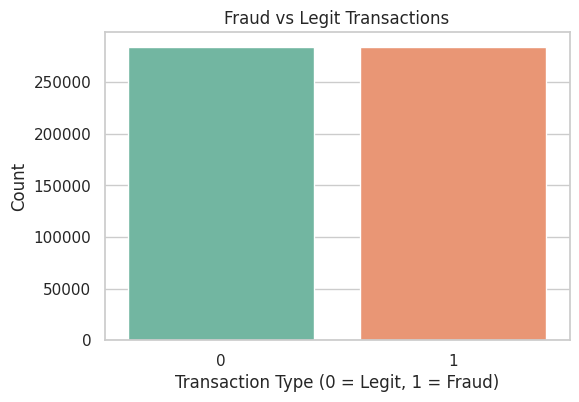

Fraudulent Transactions Ratio: 50.0000%


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Class distribution count
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df, palette='Set2')
plt.title("Fraud vs Legit Transactions")
plt.xlabel("Transaction Type (0 = Legit, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

# Ratio print
fraud_ratio = (df['Class'].sum() / len(df)) * 100
print(f"Fraudulent Transactions Ratio: {fraud_ratio:.4f}%")


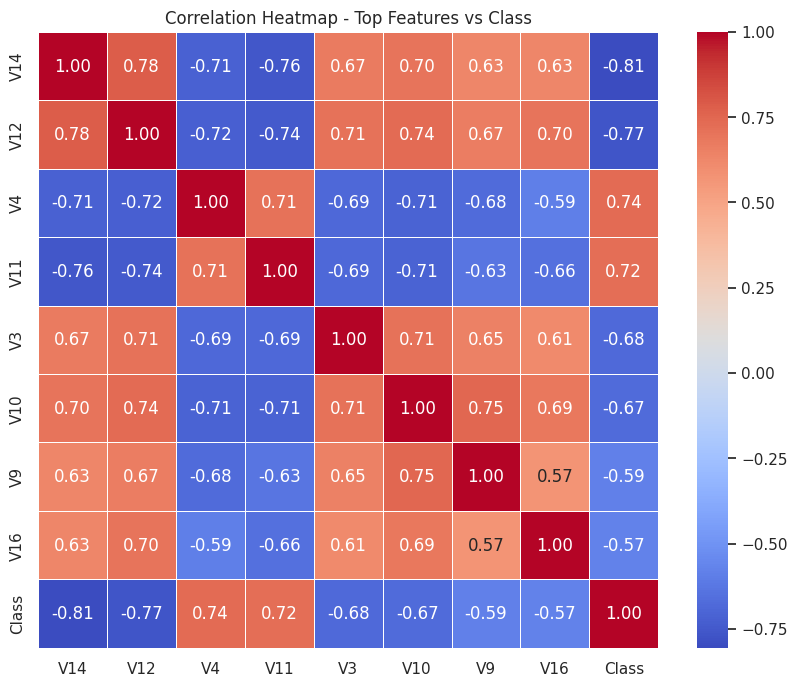

In [7]:
import numpy as np

# Step 1: Correlation matrix
corr_matrix = df.corr()

# Step 2: Select top N features most correlated with 'Class'
top_features = corr_matrix['Class'].abs().sort_values(ascending=False)[1:9].index.tolist()

# Step 3: Plot heatmap with selected features + Class
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_features + ['Class']].corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap - Top Features vs Class")
plt.show()


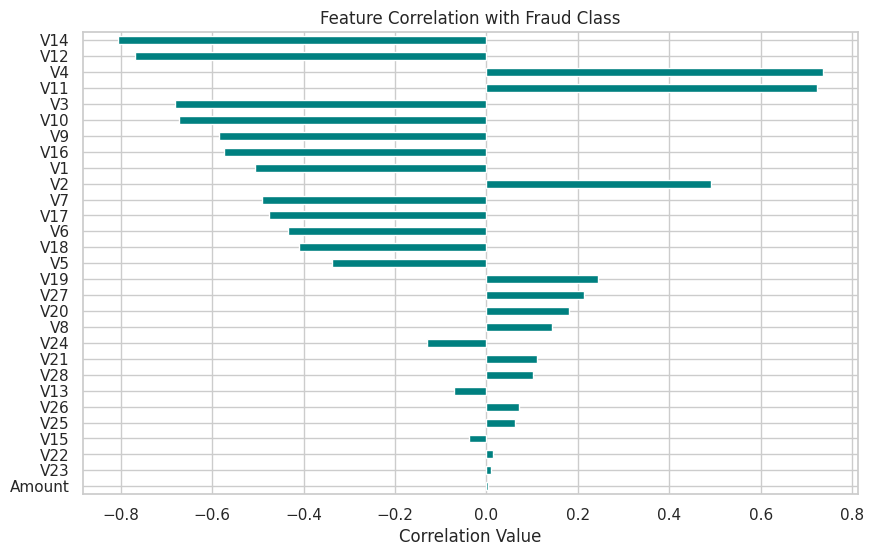

In [8]:
# Bar plot of absolute correlations with Class
class_corr = corr_matrix['Class'].drop('Class').sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
class_corr.plot(kind='barh', color='teal')
plt.title('Feature Correlation with Fraud Class')
plt.xlabel('Correlation Value')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


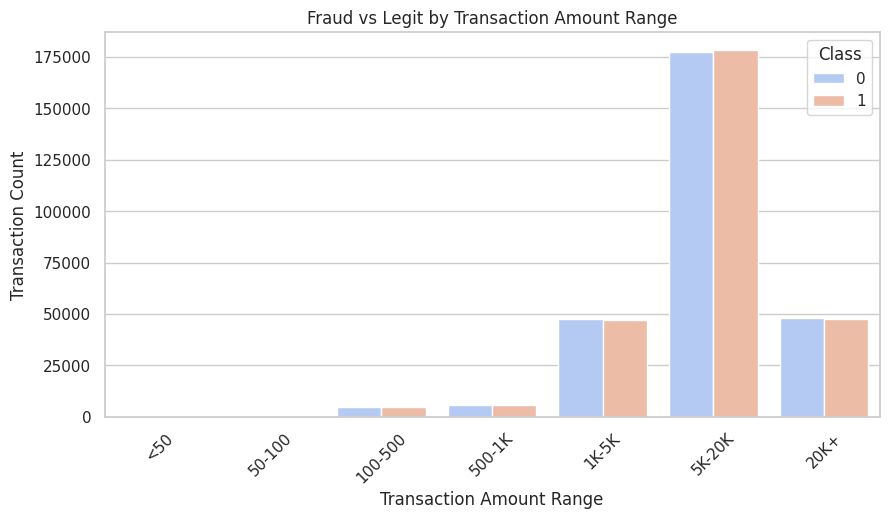

In [9]:
# Create buckets
df['Amount_Range'] = pd.cut(df['Amount'], bins=[0, 50, 100, 500, 1000, 5000, 20000, np.inf],
                             labels=['<50', '50-100', '100-500', '500-1K', '1K-5K', '5K-20K', '20K+'])

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Amount_Range', hue='Class', palette='coolwarm')
plt.title("Fraud vs Legit by Transaction Amount Range")
plt.xlabel("Transaction Amount Range")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.show()


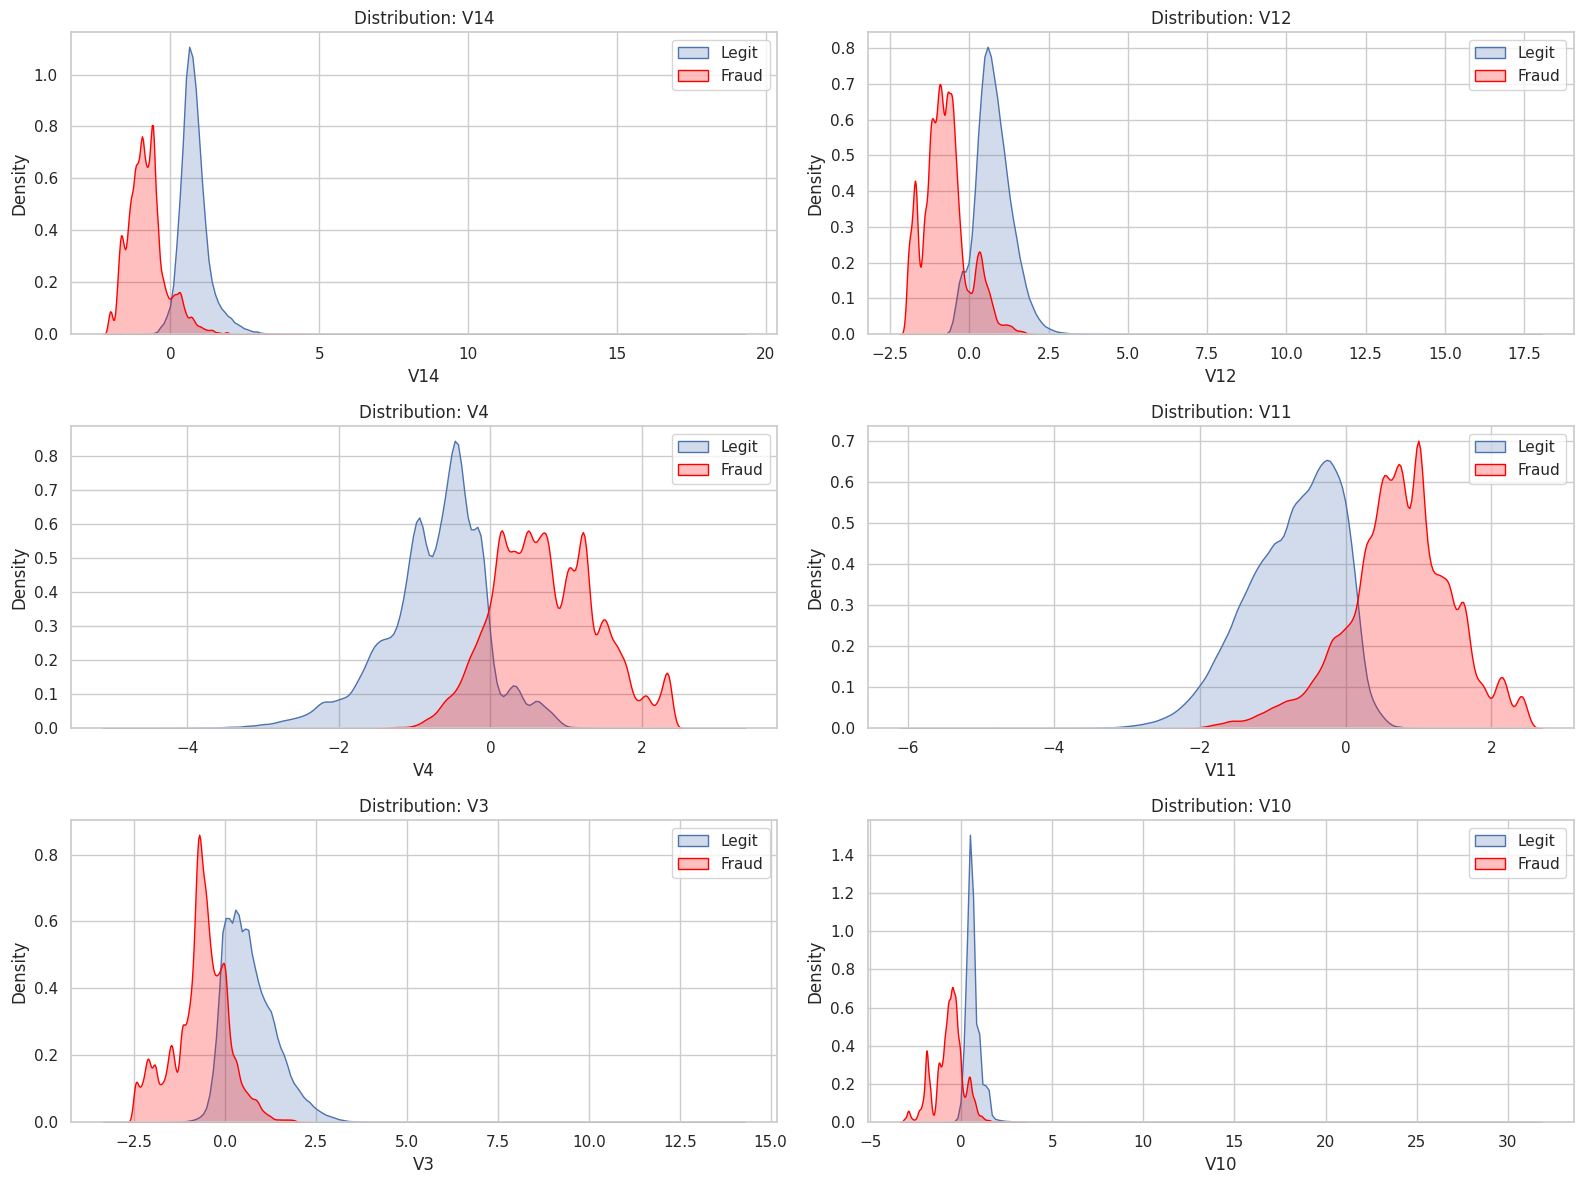

In [10]:
# Get features most correlated with fraud (top absolute correlations)
top_corr_features = corr_matrix['Class'].abs().sort_values(ascending=False)[1:7].index.tolist()

# Plot KDE distributions
plt.figure(figsize=(16, 12))
for idx, feature in enumerate(top_corr_features):
    plt.subplot(3, 2, idx+1)
    sns.kdeplot(df[df['Class'] == 0][feature], label='Legit', fill=True)
    sns.kdeplot(df[df['Class'] == 1][feature], label='Fraud', fill=True, color='red')
    plt.title(f'Distribution: {feature}')
    plt.legend()
plt.tight_layout()
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop ID if not done earlier and set features
X = df.drop(columns=['Class', 'id'], errors='ignore')
y = df['Class']

# Standardize 'Amount' (others are already PCA-like scaled)
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])

# Split into Train/Test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (454904, 30), Test shape: (113726, 30)


In [12]:
# Drop unnecessary/EDA-only columns if present
X = df.drop(columns=['Class', 'id', 'Amount_Range'], errors='ignore')


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features and target
X = df.drop(columns=['Class', 'id', 'Amount_Range'], errors='ignore')
y = df['Class']

# Scale 'Amount'
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize a faster RF with fewer trees
rf_model = RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("=== Random Forest Classifier Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


=== Random Forest Classifier Metrics ===
Accuracy: 0.9731108101929198
ROC AUC Score: 0.9977760670533198

Classification Report:

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     56863
           1       1.00      0.95      0.97     56863

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726



In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Train logistic regression
log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_model.fit(X_train, y_train)

# Predict
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

# Evaluation
print("=== Logistic Regression Classifier Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_log))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_log))


=== Logistic Regression Classifier Metrics ===
Accuracy: 0.9649420537080351
ROC AUC Score: 0.9935033429195056

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.97      0.96      0.96    113726
weighted avg       0.97      0.96      0.96    113726



In [15]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Initialize XGBoost model with scale_pos_weight to handle imbalance
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=10,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("=== XGBoost Classifier Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_xgb))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_xgb))


=== XGBoost Classifier Metrics ===
Accuracy: 0.9951198494627438
ROC AUC Score: 0.999906589680161

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.99      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



In [16]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import pandas as pd

X_train_sample = X_train.sample(frac=0.1, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]
X_test_sample = X_test.sample(frac=0.1, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

# Train faster SVM
svm_fast = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_fast.fit(X_train_sample, y_train_sample)

# Predict
y_pred_svm = svm_fast.predict(X_test_sample)
y_prob_svm = svm_fast.predict_proba(X_test_sample)[:, 1]

# Evaluate
print("=== SVM (Sampled) Classifier Metrics ===")
print("Accuracy:", accuracy_score(y_test_sample, y_pred_svm))
print("ROC AUC Score:", roc_auc_score(y_test_sample, y_prob_svm))
print("\nClassification Report:\n")
print(classification_report(y_test_sample, y_pred_svm))


=== SVM (Sampled) Classifier Metrics ===
Accuracy: 0.9892728391805152
ROC AUC Score: 0.9991820227977164

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5646
           1       0.99      0.99      0.99      5727

    accuracy                           0.99     11373
   macro avg       0.99      0.99      0.99     11373
weighted avg       0.99      0.99      0.99     11373



In [17]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score

# Train Isolation Forest (unsupervised — only on legit class)
iso_model = IsolationForest(contamination=0.001, random_state=42)
iso_model.fit(X_train)

# Predict: -1 = outlier (fraud), 1 = inlier (legit)
y_pred_iso = iso_model.predict(X_test)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

# Evaluation
print("=== Isolation Forest Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_iso))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_iso))


=== Isolation Forest Metrics ===
Accuracy: 0.5010024092995445

Classification Report:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     56863
           1       1.00      0.00      0.00     56863

    accuracy                           0.50    113726
   macro avg       0.75      0.50      0.34    113726
weighted avg       0.75      0.50      0.34    113726



In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Train autoencoder only on legit transactions
X_train_ae = X_train[y_train == 0]

# Define Autoencoder architecture
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(X_train_ae, X_train_ae,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_split=0.1,
                verbose=1)

# Predict reconstruction on test data
reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.power(X_test - reconstructed, 2), axis=1)

# Set threshold for classification (95th percentile)
threshold = np.percentile(reconstruction_error, 95)
y_pred_ae = np.where(reconstruction_error > threshold, 1, 0)

# Evaluation
print("=== Autoencoder (Anomaly Detection) Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_ae))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_ae))


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5104 - val_loss: 0.2730
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2673 - val_loss: 0.2526
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2450 - val_loss: 0.2378
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2381 - val_loss: 0.2276
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2504 - val_loss: 0.2208
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2259 - val_loss: 0.2157
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2231 - val_loss: 0.2108
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2208 - val_loss: 0.2081
Epoch 9/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2077 - val_loss: 0.2058
Epoch 10/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2051 - val_loss: 0.2042
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
=== Autoencoder (Anomaly Detection) Metrics ===
Accuracy: 0.5480716810579814

Classification Rep

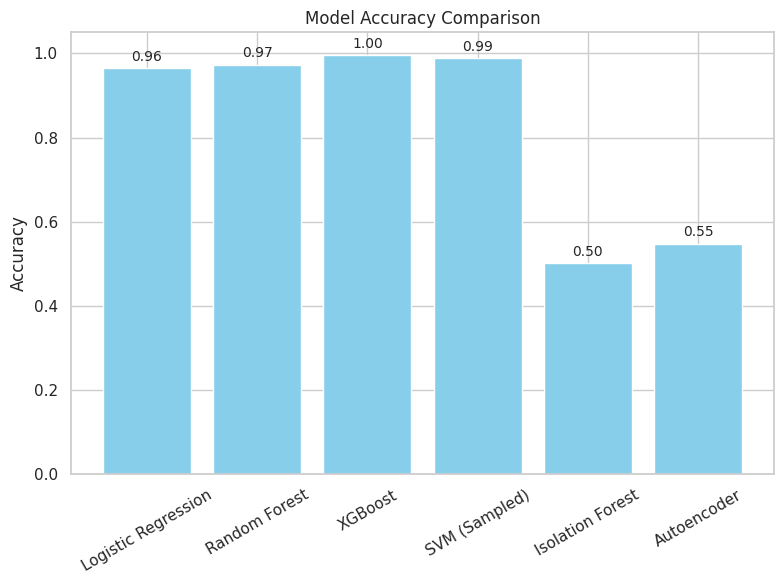

In [20]:
import matplotlib.pyplot as plt

# Model names and accuracies
models = [
    'Logistic Regression',
    'Random Forest',
    'XGBoost',
    'SVM (Sampled)',
    'Isolation Forest',
    'Autoencoder'
]

accuracies = [
    0.9649,  # Logistic Regression
    0.9731,  # Random Forest
    0.9951,  # XGBoost
    0.9893,  # SVM (Sampled)
    0.5010,  # Isolation Forest
    0.5480   # Autoencoder
]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color='skyblue')
plt.ylim(0, 1.05)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)

# Annotate bars with accuracy values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{acc:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [25]:
# Install widgets (if not already installed)
!pip install -q ipywidgets

# Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# Step 1: Get first legit row as default input values
default_row = df[df['Class'] == 0].iloc[0]

# Step 2: Feature List
feature_names = ['V' + str(i) for i in range(1, 29)] + ['Amount']

# Step 3: Create UI input fields with rounded defaults
inputs = {
    feat: widgets.FloatText(
        value=round(default_row[feat], 2),
        description=f'{feat}:',
        layout=widgets.Layout(width='300px')
    ) for feat in feature_names
}

# Step 4: Create UI elements
predict_button = widgets.Button(description="🔍 Predict Fraud", button_style='danger', layout=widgets.Layout(width='300px'))
output = widgets.Output()
header_html = widgets.HTML("<h2 style='color:#2b7a78;'>💳 Credit Card Fraud Detection</h2>")

# Step 5: Prediction Function
def predict_fraud(b):
    input_values = {feat: [inputs[feat].value] for feat in feature_names}
    input_df = pd.DataFrame(input_values)

    # Scale 'Amount'
    input_df['Amount'] = scaler.transform(input_df[['Amount']])

    try:
        # Prediction
        prob = xgb_model.predict_proba(input_df)[0][1]
        pred = xgb_model.predict(input_df)[0]

        with output:
            output.clear_output()
            display(HTML("<h4 style='color:darkblue;'>🎯 Prediction Result:</h4>"))
            print(f"Prediction: {'🚨 Fraudulent' if pred == 1 else '✅ Legit'}")
            print(f"Fraud Probability: {prob:.4f}")
    except Exception as e:
        with output:
            output.clear_output()
            print("⚠️ Error during prediction:", str(e))

# Step 6: Bind button to function
predict_button.on_click(predict_fraud)

# Step 7: Layout
form_items = [inputs[f] for f in feature_names]
grid = widgets.GridBox(form_items, layout=widgets.Layout(grid_template_columns="repeat(3, 33%)"))

# Step 8: Display UI
display(widgets.VBox([header_html, grid, predict_button, output]))


In [27]:
# Install ipywidgets if not already
!pip install -q ipywidgets

import pandas as pd
import ipywidgets as widgets
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML

# Full list of expected features
all_features = ['V' + str(i) for i in range(1, 29)] + ['Amount']

# Top 8 user-input features
top_features = ['V14', 'V10', 'V12', 'V4', 'V17', 'V3', 'V7', 'Amount']

# Default row
default_row = df[df['Class'] == 0].iloc[0]

# UI inputs for top features only
inputs = {
    feat: widgets.FloatText(
        value=round(default_row[feat], 2),
        description=f'{feat}:',
        layout=widgets.Layout(width='300px')
    ) for feat in top_features
}

# Prediction button and output area
predict_button = widgets.Button(description="🔍 Predict Fraud", button_style='danger', layout=widgets.Layout(width='300px'))
output = widgets.Output()
header_html = widgets.HTML("<h2 style='color:#2b7a78;'>💳 Credit Card Fraud Detection (Top Features Only)</h2>")


def predict_fraud(b):
    # Collect user input
    input_values = {feat: inputs[feat].value for feat in top_features}


    full_input = {feat: [input_values[feat] if feat in input_values else 0.0] for feat in all_features}
    input_df = pd.DataFrame(full_input)

    # Scale Amount
    input_df['Amount'] = scaler.transform(input_df[['Amount']])

    # Predict
    try:
        prob = xgb_model.predict_proba(input_df)[0][1]
        pred = xgb_model.predict(input_df)[0]

        with output:
            output.clear_output()
            display(HTML("<h4 style='color:darkblue;'>🎯 Prediction Result:</h4>"))
            print(f"Prediction: {'🚨 Fraudulent' if pred == 1 else '✅ Legit'}")
            print(f"Fraud Probability: {prob:.4f}")
    except Exception as e:
        with output:
            output.clear_output()
            print("⚠️ Error during prediction:", str(e))

# Bind button
predict_button.on_click(predict_fraud)

# UI layout
form_items = [inputs[f] for f in top_features]
grid = widgets.GridBox(form_items, layout=widgets.Layout(grid_template_columns="repeat(2, 50%)"))

# Display
display(widgets.VBox([header_html, grid, predict_button, output]))
